In [1]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None
data_root = '.'

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?' + str(statinfo.st_size))
  return dest_filename

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)

Found and verified .\train.tar.gz
Found and verified .\test.tar.gz


In [4]:
num_classes = 0
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
    
maybe_extract(train_filename)
maybe_extract(test_filename)

.\train already present - Skipping extraction of .\train.tar.gz.
.\test already present - Skipping extraction of .\test.tar.gz.


In [7]:
# Extract the information from the mat files into json. 
# taken from http://www.a2ialab.com/lib/exe/fetch.php?media=public:scripts:svhn_dataextract_tojson.py.txt

def reformat_digitstruct():    
    for a in ['test', 'train']:
        filename = os.path.join(a, 'digitStruct.json')
        if os.path.isfile(filename):
            print("Already extracted %s, skipping" % filename)
        else:
            cmd = str.format("python svhn_dataextract_tojson.py -f {0}/digitStruct.mat -o {0}/digitStruct", a)
            print("Executing:%s" % cmd)
            result = os.system(cmd)
print('Extracting label and bounding box information')
reformat_digitstruct()
print('...done')

Extracting label and bounding box information
Already extracted test\digitStruct.json, skipping
Already extracted train\digitStruct.json, skipping
...done


In [9]:
# Extract the information from the json files

import json
import pandas as pd
from PIL import Image, ImageDraw
import pickle
import seaborn as sns
colors = sns.color_palette()

def load_file_meta(folder):
    results = []
    filename = os.path.join(folder, 'digitStruct.json')
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    for file_info in data:
        pic_info = {}
        pic_info['boxes'] = [{a : int(item[a]) for a in ['top', 'left', 'height', 'width']}
                             for item in file_info['boxes']]
        pic_info['label'] = np.array([int(item['label']) % 10 for item in file_info['boxes']])
        pic_info['filename'] = os.path.join(folder, file_info['filename'])
        
        # Calculate the bounding box of the numbers
        x1 = pic_info['boxes'][0]['left']
        x2 = pic_info['boxes'][-1]['left'] + pic_info['boxes'][-1]['width']
        
        y1 = np.min([b['top'] for b in pic_info['boxes']])
        y2 = np.max([b['top'] + b['height'] for b in pic_info['boxes']])
        
        pic_info['bbox'] = [x1, y1, x2, y2]
        pic_info['bbox_x'] = [x1, x2]
        pic_info['bbox_y'] = [y1, y2]
        pic_info['bbox_width'] = x2 - x1
        pic_info['bbox_height'] = y2 - y1
        pic_info['center_x'] = (x1 + x2) // 2
        pic_info['center_y'] = (y1 + y2) // 2
        pic_info['center'] = [pic_info['center_x'], pic_info['center_y']]
        
        results.append(pic_info)
    return results

test_info = load_file_meta('test')
train_info = load_file_meta('train')
print('Done!')

Done!


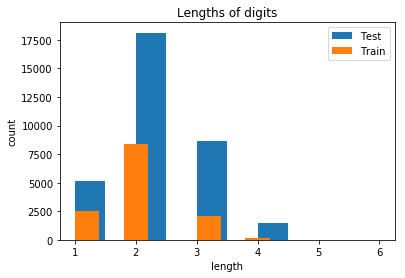

Training number length
len
1     5137
2    18130
3     8691
4     1434
5        9
6        1
Name: label, dtype: int64
Test number length
len
1    2483
2    8356
3    2081
4     146
5       2
Name: label, dtype: int64


In [10]:
# Let's investigate our dataset
def show_hist(data, **kwargs):    
    plt.hist(data, **kwargs)

df_train = pd.DataFrame(data=train_info)
df_test = pd.DataFrame(data=test_info)

df_train['len'] = df_train['label'].map(len)
df_test['len'] = df_test['label'].map(len)

show_hist(df_train['len'])
show_hist(df_test['len'])
plt.title('Lengths of digits')
plt.xlabel('length')
plt.ylabel('count')
plt.legend(['Test', 'Train'])
plt.show()

print("Training number length")
print(df_train.groupby('len').count()['label'])

print("Test number length")
print(df_test.groupby('len').count()['label'])

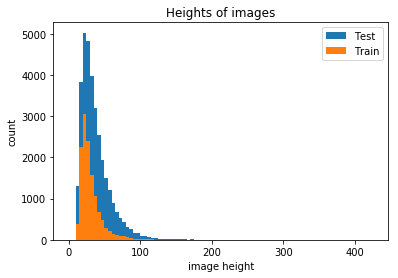

Train (min/max)
9 423
Test (min/max)
10 222
Train shape
(33402, 12)
Test shape
(13068, 12)


In [11]:
#Investigating the quality of images.

bin_size = 5
data = df_train['bbox_height']
bins=np.arange(0, max(data) + bin_size, bin_size)
show_hist(data, bins=bins)
show_hist(df_test['bbox_height'], bins=bins)
plt.title('Heights of images')
plt.xlabel('image height')
plt.ylabel('count')
plt.legend(['Test', 'Train'])
plt.show()

print("Train (min/max)")
print(np.min(df_train['bbox_height']), np.max(df_train['bbox_height']))
print("Test (min/max)")
print(np.min(df_test['bbox_height']), np.max(df_test['bbox_height']))


print("Train shape")
print(df_train.shape)
print("Test shape")
print(df_test.shape)

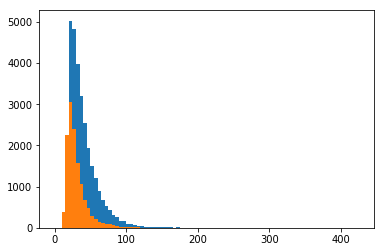

New training shape size
(28259,)
(28259, 12)
Testing shape size
(13068, 12)


In [12]:
#removing low quality images, i.e., images with height less than 20

min_height = 20
df_train = df_train.loc[(df_train.bbox_height >= min_height)]

train_info = np.array(train_info)[df_train.index]
data = df_train['bbox_height'].values
show_hist(data, bins=bins)
show_hist(df_test['bbox_height'], bins=bins)
plt.show()

print("New training shape size")
print(train_info.shape)
print(df_train.shape)
print("Testing shape size")
print(df_test.shape)

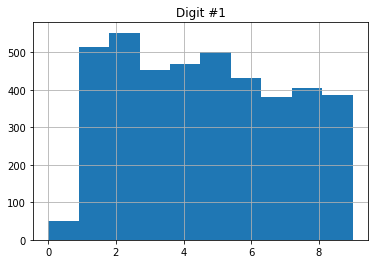

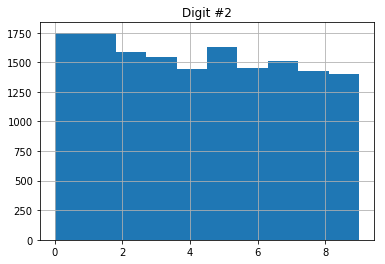

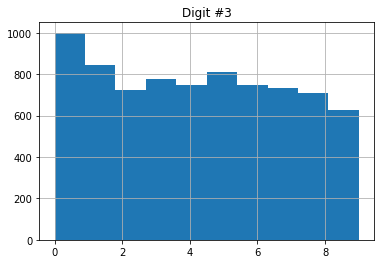

In [13]:
# Frequencies of digits in each position i.e 1-9
for i in range(3):
    df_train[df_train.len==i+1]['label'].apply(lambda x: x[i]).hist()
    plt.title("Digit #%d" % (i+1))
    plt.show()

In [15]:
#Processing images in many threads.

import os
from scipy import ndimage
import scipy.misc as spm
import scipy.ndimage as spn
from multiprocessing import Pool
from functools import partial

def pre_process_file(pic_info, show=False):
    img_height = 56 # Chosen to work with the Android camera app nicely
    img_width = 56
    image_file = pic_info['filename']

    if show:
        im = Image.open(pic_info['filename'])
        draw = ImageDraw.Draw(im)
        draw.rectangle(pic_info['bbox'])
        draw.rectangle([pic_info['center'][j]  + k for j, k in zip([0, 1, 0, 1], [-1, -1, 1, 1])])
        
    image_data = ndimage.imread(image_file, flatten=True).astype(float)
    
    # Calc a space around the digits as a buffer based on the y axis
    buff_size = int((pic_info['center_y'] - pic_info['bbox_y'][0]) * .4)
  
    # Create our ideal bounding box      
    x_start = pic_info['bbox_x'][0] - buff_size
    x_end = pic_info['bbox_x'][1] + buff_size
    
    y_start = pic_info['bbox_y'][0] - buff_size
    y_end = pic_info['bbox_y'][1] + buff_size
    
    dy, dx = y_end-y_start, x_end-x_start
    
    
    if dx > dy:
        y_start -= (dx - dy) // 2
        y_end = y_start + dx
    else:
        x_start -= (dy - dx) // 2
        x_end = x_start + dy
        
    dy, dx = y_end-y_start, x_end-x_start
        
    max_size = np.max([dx, dy])
    n_x_start, n_x_end = 0, dx
    n_y_start, n_y_end = 0, dy

    if x_start < 0:
        diff = 0-x_start
        n_x_start += diff
        x_start += diff        
        
    if y_start < 0:
        diff = 0-y_start
        n_y_start += diff
        y_start += diff
        
    if y_end > image_data.shape[0]:
        diff = y_end - image_data.shape[0]
        y_end -= diff
        n_y_end -= diff
                    
    if x_end > image_data.shape[1]:
        diff = x_end - image_data.shape[1]
        x_end -= diff
        n_x_end -= diff
        
    if show:
       draw.rectangle([x_start, y_start, x_end, y_end])
       
    square_output = np.ones([max_size, max_size]) * np.mean(image_data)
    
    square_output[n_y_start:n_y_end, n_x_start:n_x_end] = \
        image_data[y_start:y_end, x_start:x_end]
        
    factor = 1.0 * img_height / square_output.shape[0]
    img_zoomed = spn.interpolation.zoom(square_output, factor)
            
    img_colors = img_zoomed.astype(np.float32) - np.min(square_output)
    img_colors = img_colors / np.max(img_colors) - 0.5

    if show:
        print('*' * 60)
        print("Original", image_data.shape)
        print("Cropped", img_colors.shape)
        plt.figure(figsize=(3,3))
        plt.axis('off')
        plt.imshow(im)
        plt.show()
        print("Filename:%s" % pic_info['filename'])
        print("Label:%s" % pic_info['label'])
        print("Color range:", np.max(img_colors), np.min(img_colors))
        plt.imshow(img_colors, cmap=plt.get_cmap('jet'))
        plt.show()

    return img_colors, pic_info['label']

sns.set_style("white")
np.random.shuffle(train_info)
print('Done!')

Done!


Processing images


c:\users\navneet\desktop\udacity\ml\deeplearning\digicam\myvenv\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
c:\users\navneet\desktop\udacity\ml\deeplearning\digicam\myvenv\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
c:\users\navneet\desktop\udacity\ml\deeplearning\digicam\myvenv\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


[1 8]


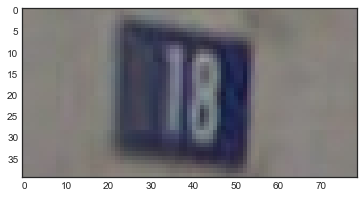

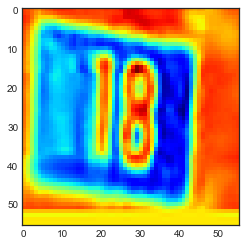

[2 2 9]


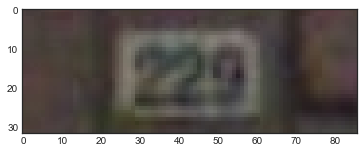

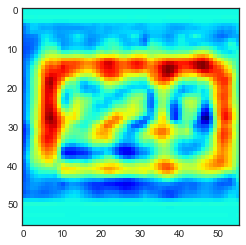

[5 8]


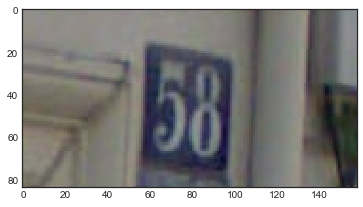

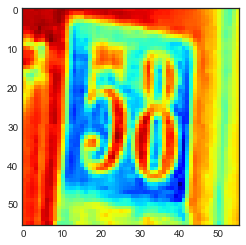

In [16]:
def generate_batch_parallel(pic_info_list, show=False):
    """Load the data for a single letter label."""
    
    # For linux use this
    if os.name != 'nt':
        pool = Pool()
        results = pool.map(partial(pre_process_file), pic_info_list)
        pool.close()
        pool.join()
    else:
        # For windows use this
        results = [pre_process_file(a, show) for a in pic_info_list]
    
    imgs, labels = zip(*results)
    return np.array(imgs), np.array(labels)
    
print('Processing images')
np.random.shuffle(train_info)
tmp_pics, tmp_labels = generate_batch_parallel(train_info[:3])

for i, tmp_label in enumerate(tmp_labels):
    print(tmp_label)
    image_data = ndimage.imread(train_info[i]['filename'])
    plt.imshow(image_data)
    plt.show()
    plt.imshow(tmp_pics[i], cmap=plt.get_cmap('jet'))
    plt.show()

In [17]:
# Saving the processed images

for name, info in [('train', train_info), ('test', test_info)]:
    print('Generating:%s' % name)
    print('Size:%d' % len(info))
    pics, labels = generate_batch_parallel(info)
    
    pickle_file = 'SVHN_%s.pickle' % name
    print("Saving:%s" % pickle_file)

    try:
      f = open(pickle_file, 'wb')
      save = {
        'dataset': pics,
        'labels': labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:%dmb' % (statinfo.st_size // 1024**2))
    
print("Done")

Generating:train
Size:28259


c:\users\navneet\desktop\udacity\ml\deeplearning\digicam\myvenv\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
c:\users\navneet\desktop\udacity\ml\deeplearning\digicam\myvenv\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Saving:SVHN_train.pickle
Compressed pickle size:339mb
Generating:test
Size:13068
Saving:SVHN_test.pickle
Compressed pickle size:156mb
Done
